In [3]:
import torch
import pickle
from torch import nn
import gzip
import numpy as np

In [4]:
path="fashion_data/"

label_file=gzip.open(path + 'train-labels-idx1-ubyte.gz')
y_train= np.frombuffer(label_file.read(), dtype=np.uint8, offset=8)

image_file=gzip.open(path + 'train-images-idx3-ubyte.gz', 'rb')
x_train= np.frombuffer(image_file.read(), dtype=np.uint8, offset=16).reshape(len(y_train), 784)

valid_label_file=gzip.open(path + 't10k-labels-idx1-ubyte.gz')
y_valid= np.frombuffer(valid_label_file.read(), dtype=np.uint8, offset=8)

valid_image_file=gzip.open(path + 't10k-images-idx3-ubyte.gz', 'rb')
x_valid= np.frombuffer(valid_image_file.read(), dtype=np.uint8, offset=16).reshape(len(y_valid), 784)

In [5]:
x_train = torch.tensor(x_train, dtype=torch.float)
x_test = torch.tensor(x_valid, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test= torch.tensor(y_valid, dtype=torch.long)

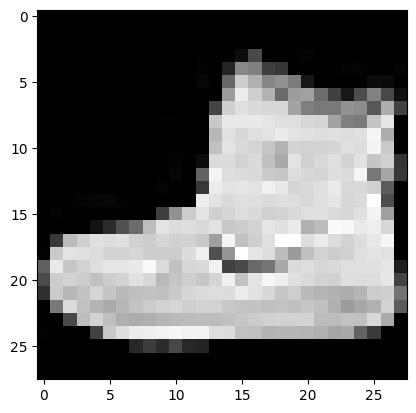

In [6]:
import matplotlib.pyplot as plt

plt.imshow(x_train[0].reshape(28, 28), cmap='gray')

In [7]:
y_train[0]

tensor(9)

Each training and test example is assigned to one of the following labels:

- 0 T-shirt/top
- 1	Trouser
- 2	Pullover
- 3	Dress
- 4	Coat
- 5	Sandal
- 6	Shirt
- 7	Sneaker
- 8	Bag
- 9	Ankle boot

In [8]:
x_train[0].shape

torch.Size([784])

In [9]:
class MySimpleNN(torch.nn.Module):   # MySimpleNN erbt von torch.nn.Module

    # Constructor
    def __init__(self,input_size=11,hidden_size=(10,20,10),output_size=1):
        # Aufruf des Superkonstruktors von torch.nn.Module
        super(MySimpleNN, self).__init__()
        # Definition der Schichten
        #definiert die Anzahl der Neuronen in den Schichten
        self.fc1 = torch.nn.Linear(input_size, hidden_size[0])
        self.fc2 = torch.nn.Linear(hidden_size[0], hidden_size[1])
        self.fc3 = torch.nn.Linear(hidden_size[1], hidden_size[2])
        self.fc4 = torch.nn.Linear(hidden_size[2], output_size)

        # Batch Normalization
        # 70, 120, 30 sind die Anzahl der Neuronen in den Schichten
        self.bn1 = torch.nn.BatchNorm1d(hidden_size[0])
        self.bn2 = torch.nn.BatchNorm1d(hidden_size[1])
        self.bn3 = torch.nn.BatchNorm1d(hidden_size[2])
    # forward Methode -> Forward Propagation
    # wenn ich später ein Objekt von MySimpleNN erzeuge, dann kann ich
    # dieses Objekt mit einem Tensor aufrufen, dann wird die forward Methode
    # aufgerufen. z.B. model(x_train)
    def forward(self, xb):   # xb steht für eine Batch von X-Werten
        #print("xb", xb.shape)
        z2 = self.fc1(xb)  # dahinter steckt x@w1 + b1
        a2 = torch.relu(z2)    # alle negativen Werte werden auf 0 gesetzt, der Rest bleibt
        #print("a2", a2.shape)
        a2_bn = self.bn1(a2) # Normalisierung der Werte auf den Neuronen
        #print("a2_bn", a2_bn.shape)
        z3 = self.fc2(a2_bn) # dahinter steckt a2@w2 + b2
        #print("z3", z3.shape)
        a3 = torch.relu(z3)
        #print("a3", a3.shape)
        a3_bn = self.bn2(a3)
        #print("a3_bn", a3_bn.shape)
        z4 = self.fc3(a3_bn)
        #print("z4", z4.shape)
        a4 = torch.relu(z4)
        #print("a4", a4.shape)
        a4_bn = self.bn3(a4)
        #print("a4_bn", a4_bn.shape)
        y_hat = torch.relu(self.fc4(a4_bn))
        #print("y_hat", y_hat.shape)
        return y_hat

In [10]:
def get_batch(x, y, batch_size):
    # z.B. range(0, 10, 3) --> 0, 3, 6, 9
    # range(start, stop, step)
    for i in range(0, len(x), batch_size):
        # yield: gibt den Wert zurück, aber merkt sich den aktuellen Zustand
        yield x[i:i+batch_size], y[i:i+batch_size]

# returns argmax
def get_prediction(output):
    return torch.argmax(output, dim=1)

Epoch 00171: reducing learning rate of group 0 to 1.0000e-05.


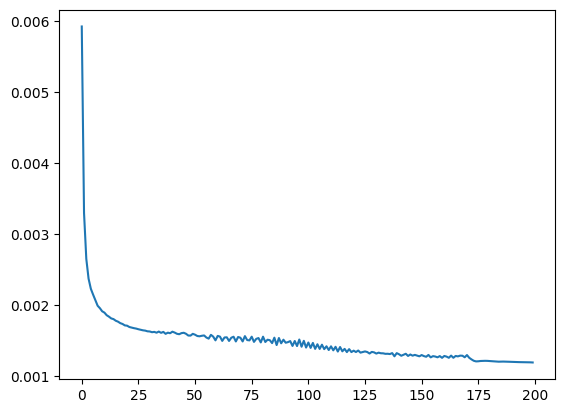

In [11]:
# eigenes Modell wird erstellt
model = MySimpleNN(input_size=784, hidden_size=(70,120,30),output_size=10)
lr=0.0001
# trainiere immer mit 10 Datensätzen auf einmal
batch_size=40

# loss function
# Mean Squared Error
# die Lossfunction von Pytorch müssen erstmal erstellt werden mit ()
loss_fn = nn.CrossEntropyLoss()
optemizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optemizer, mode='min', factor=0.1, patience=10, verbose=True, threshold=0.0001)

def train(xb, yb):
    y_hat=model(xb)
    loss = loss_fn(y_hat, yb)
    loss.backward()
    optemizer.step()
    return loss.item()

losses=[]
for epoch in range(200):
    loss_sum=0
    # Iteration über alle Batches
    for xb, yb in get_batch(x_train, y_train, batch_size):
        loss_sum += train(xb, yb)
    losses.append(loss_sum/len(x_train))
    scheduler.step(losses[-1])
#plot
plt.plot(losses)

In [16]:
#calculate mean error
error_list=[]

y_pred=get_prediction(model(x_test))
correct=sum(y_pred==y_test)

print("mean error:", correct/len(y_test))

mean error: tensor(0.8771)
